# EDA and Cleaning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import psycopg2 as pg2
from sqlalchemy import create_engine

from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import pairwise_distances

sns.set_style('darkgrid')
sns.set_palette(palette='colorblind')
%matplotlib inline

In [2]:
%run ../bx_sql.py

In [3]:
engine = create_engine(f'postgres://{USER}:{PASSWORD}@{FULL_IP_ADDRESS}:5432/{DBNAME}')

## Configure PostgreSQL Server with Docker

In [4]:
# def con_cur_to_db(dbname=DBNAME, dict_cur=None):
#     con = pg2.connect(host=IP_ADDRESS,
#                   dbname=dbname,
#                   user=USER,
#                   password=PASSWORD)
#     if dict_cur:
#         cur = con.cursor(cursor_factory=RealDictCursor)
#     else:
#         cur = con.cursor()
#     return con, cur
    
# def execute_query(query, dbname=DBNAME, dict_cur=None, command=False):
#     con, cur = con_cur_to_db(dbname, dict_cur)
#     cur.execute(f'{query}')
#     if not command:
#         data = cur.fetchall()
#         con.close()
#         return data
#     con.commit() #sends to server
#     con.close() #closes server connection

# def insert_entry_json(data, tablename=None):
#     con, cur = con_cur_to_db()
#     for x in data:
#         cur.execute(f'INSERT INTO {tablename} (data) VALUES ({Json(x)});')
#     con.commit()
#     con.close()

## Retrieve Data from PostgreSQL Database

### Books

In [5]:
books_df = pd.read_sql_table('books', engine)

books_df.head()

,isbn,book_title,book_author,year_of_publication,publisher,image_url_s,image_url_m,image_url_l
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [6]:
# books_query = '''SELECT * FROM books;
# '''
# books_results = execute_query(books_query, dict_cur=True)

# books_df = pd.DataFrame(books_results)

### Ratings

In [7]:
ratings_df = pd.read_sql_table('book_ratings', engine)

ratings_df.head()

,user_id,isbn,book_rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [8]:
# ratings_query = '''SELECT * FROM book_ratings;
# '''

# ratings_results = execute_query(ratings_query, dict_cur=True)

# ratings_df = pd.DataFrame(ratings_results)

## Combine `books` and `ratings`

In [9]:
books_df.drop(columns=['image_url_l', 'image_url_m', 'image_url_s'], inplace=True)

In [10]:
print('Ratings ISBN:',ratings_df['isbn'].nunique())
print('Books ISBN:  ',books_df['isbn'].nunique())
ratings_df['isbn'].nunique() == books_df['isbn'].nunique()

Ratings ISBN: 340556
Books ISBN:   271379


False

In [11]:
match_isbns = ratings_df[ratings_df['isbn'].isin(books_df['isbn'])]

In [12]:
print('Number of Ratings:',match_isbns.shape[0])
print('Number of Books:  ',match_isbns['isbn'].nunique())

Number of Ratings: 1031175
Number of Books:   270170


In [13]:
match_isbns.head()

,user_id,isbn,book_rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [14]:
combined_df = match_isbns.merge(books_df[['isbn', 'book_author', 'book_title']], how='left')

In [15]:
combined_df.head()

,user_id,isbn,book_rating,book_author,book_title
0,276725,034545104X,0,M. J. Rose,Flesh Tones: A Novel
1,276726,0155061224,5,Judith Rae,Rites of Passage
2,276727,0446520802,0,Nicholas Sparks,The Notebook
3,276729,052165615X,3,Philip Prowse,Help!: Level 1
4,276729,0521795028,6,Sue Leather,The Amsterdam Connection : Level 4 (Cambridge ...


In [16]:
len(books_df[books_df[['book_title', 'book_author']].duplicated()])

20175

In [17]:
unique_books = books_df.drop_duplicates(subset=['book_author','book_title'])

In [18]:
ratings_and_books = unique_books.merge(combined_df.drop(columns=['isbn']), 
                                       on=['book_author', 'book_title'])

In [19]:
ratings_and_books.head()

,isbn,book_title,book_author,year_of_publication,publisher,user_id,book_rating
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,2,0
1,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,269782,7
2,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,8,5
3,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,11400,0
4,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,11676,8


In [20]:
ratings_and_books.shape[0] == combined_df.shape[0]

True

In [21]:
print('Users:  ', ratings_and_books['user_id'].nunique())
print('Books:  ', ratings_and_books['isbn'].nunique())
print('Ratings:', ratings_and_books.shape[0])

Users:   92107
Books:   250105
Ratings: 1031175


### Save to PostgreSQL Database

In [23]:
# ratings_and_books.to_sql(name='ratings_and_books',
#                          con=engine,
#                          if_exists='append',
#                          index=False)

## Clean Data

In [24]:
ratings_and_books.head()

,isbn,book_title,book_author,year_of_publication,publisher,user_id,book_rating
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,2,0
1,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,269782,7
2,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,8,5
3,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,11400,0
4,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,11676,8


In [25]:
ratings_and_books.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1031175 entries, 0 to 1031174
Data columns (total 7 columns):
isbn                   1031175 non-null object
book_title             1031175 non-null object
book_author            1031174 non-null object
year_of_publication    1031175 non-null int64
publisher              1031173 non-null object
user_id                1031175 non-null int64
book_rating            1031175 non-null int64
dtypes: int64(3), object(4)
memory usage: 62.9+ MB


In [26]:
ratings_and_books.isna().sum()

isbn                   0
book_title             0
book_author            1
year_of_publication    0
publisher              2
user_id                0
book_rating            0
dtype: int64

### Author

In [27]:
ratings_and_books['book_author'].nunique()

101593

COUNT DISTINCT WITH SQL

In [28]:
ratings_and_books.groupby('book_author').count()[['book_title']].head(10)

,book_title
book_author,
D. Chiel,4
J. D. Landis,1
Mimma Balia,1
'N Sync,1
142 moms from all over the world,1
1977 Inaugural Committee (U.S.),1
1st Graders of Samuel s Nixon School Carnegie Penn,1
21st Century Publishing,2
73 Magazine Editors,1


### Year of Publication

In [29]:
np.asarray(sorted(ratings_and_books['year_of_publication'].unique()))

array([   0, 1376, 1378, 1806, 1897, 1900, 1901, 1902, 1904, 1906, 1908,
       1909, 1911, 1914, 1917, 1919, 1920, 1921, 1922, 1923, 1924, 1925,
       1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936,
       1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947,
       1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958,
       1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969,
       1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980,
       1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991,
       1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
       2003, 2004, 2005, 2006, 2008, 2011, 2012, 2020, 2024, 2026, 2030,
       2037, 2038, 2050])

In [30]:
ratings_and_books[(ratings_and_books['year_of_publication'] == 0) | 
                  (ratings_and_books['year_of_publication'] > 2004)].shape[0]

14383

In [31]:
ratings_and_books[(ratings_and_books['year_of_publication'] > 0) | 
                  (ratings_and_books['year_of_publication'] < 2005)]['year_of_publication'].value_counts().index

Int64Index([2002, 2001, 1999, 2000, 2003, 1998, 1997, 1996, 1995, 1994,
            ...
            1897, 2008, 1934, 1904, 1906, 2024, 2037, 2012, 1914, 1917],
           dtype='int64', length=113)

### ISBN

In [32]:
good_isbns = ratings_and_books['isbn'].map(lambda x: x if re.findall('^[\dXx]+$', x) else None)

### Users

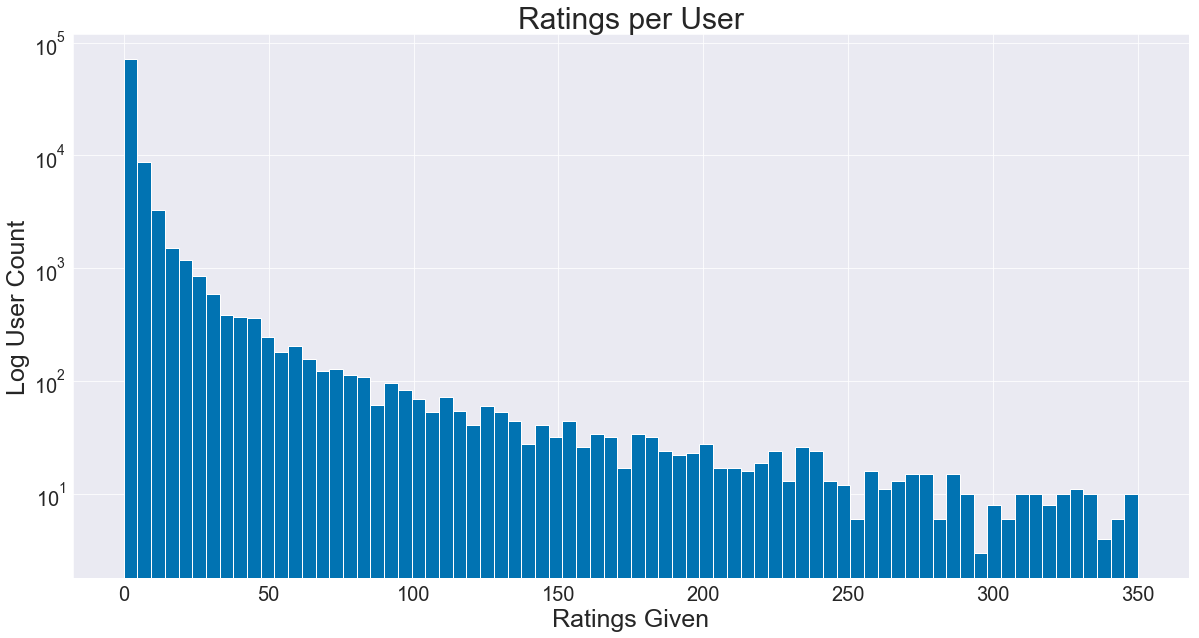

In [33]:
plt.figure(figsize=(20, 10))
plt.hist(x=ratings_and_books['user_id'].value_counts().values,
         bins=np.linspace(0, 350, 75)) 
plt.gca().set_yscale("log")
plt.title('Ratings per User', fontsize=30)
plt.xlabel('Ratings Given', fontsize=25)
plt.ylabel('Log User Count', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

### Ratings

In [34]:
ratings_and_books['book_rating'].value_counts().sort_index()

0     647323
1       1481
2       2375
3       5118
4       7617
5      45355
6      31689
7      66404
8      91806
9      60780
10     71227
Name: book_rating, dtype: int64

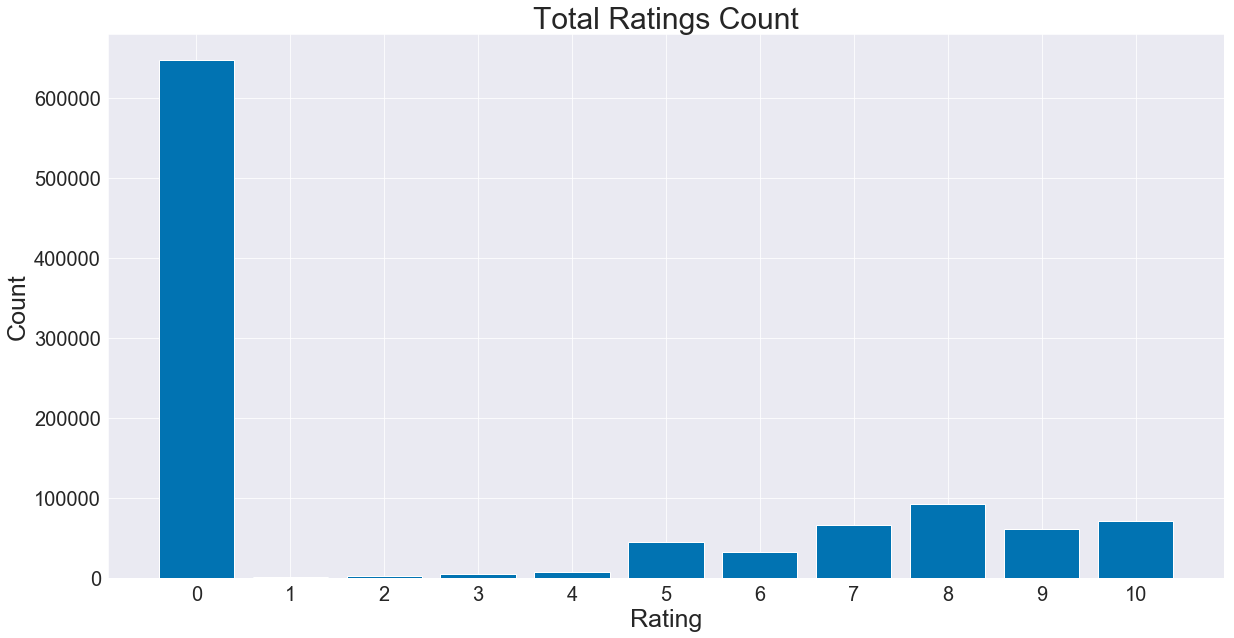

In [35]:
plt.figure(figsize=(20, 10))
plt.bar(x=ratings_and_books['book_rating'].value_counts().index,
        height=ratings_and_books['book_rating'].value_counts().values)
plt.title('Total Ratings Count', fontsize=30)
plt.xlabel('Rating', fontsize=25)
plt.ylabel('Count', fontsize=25)
plt.xticks(ratings_df['book_rating'].value_counts().index, fontsize=20)
plt.yticks(fontsize=20);

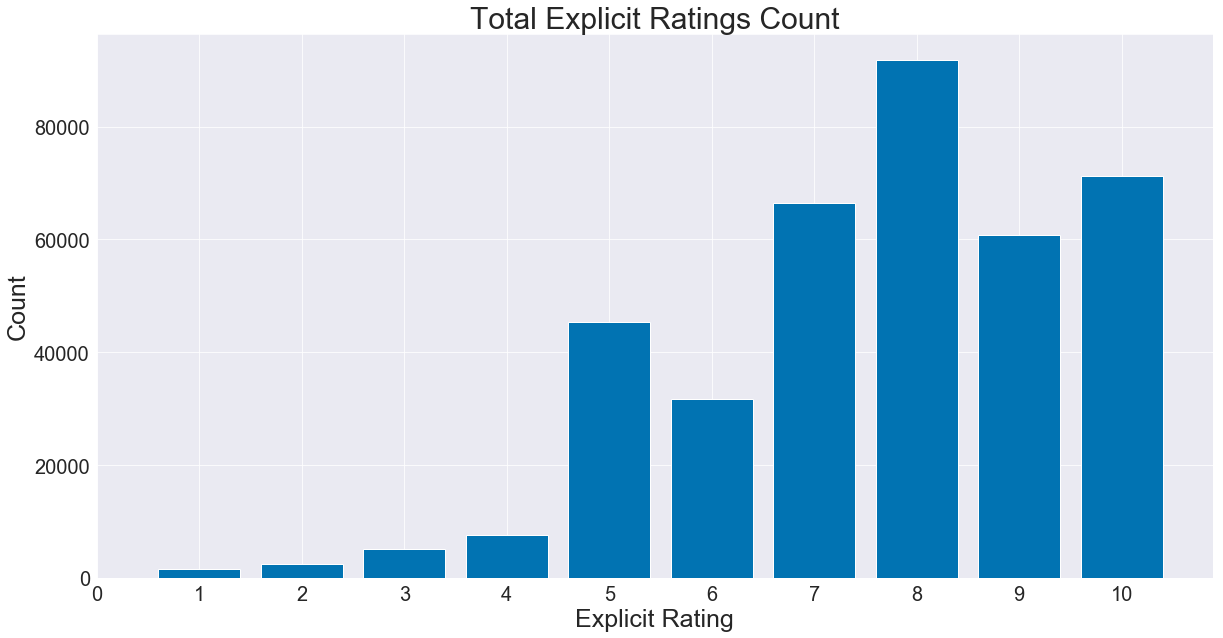

In [36]:
plt.figure(figsize=(20, 10))
plt.bar(x=ratings_and_books['book_rating'].value_counts().index[1:],
        height=ratings_and_books['book_rating'].value_counts().values[1:])
plt.title('Total Explicit Ratings Count', fontsize=30)
plt.xlabel('Explicit Rating', fontsize=25)
plt.ylabel('Count', fontsize=25)
plt.xticks(ratings_df['book_rating'].value_counts().index, fontsize=20)
plt.yticks(fontsize=20);

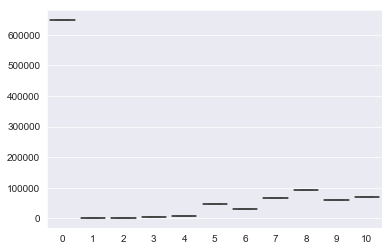

In [37]:
sns.boxplot(x=ratings_and_books['book_rating'].value_counts().index,
            y=ratings_and_books['book_rating'].value_counts().values);

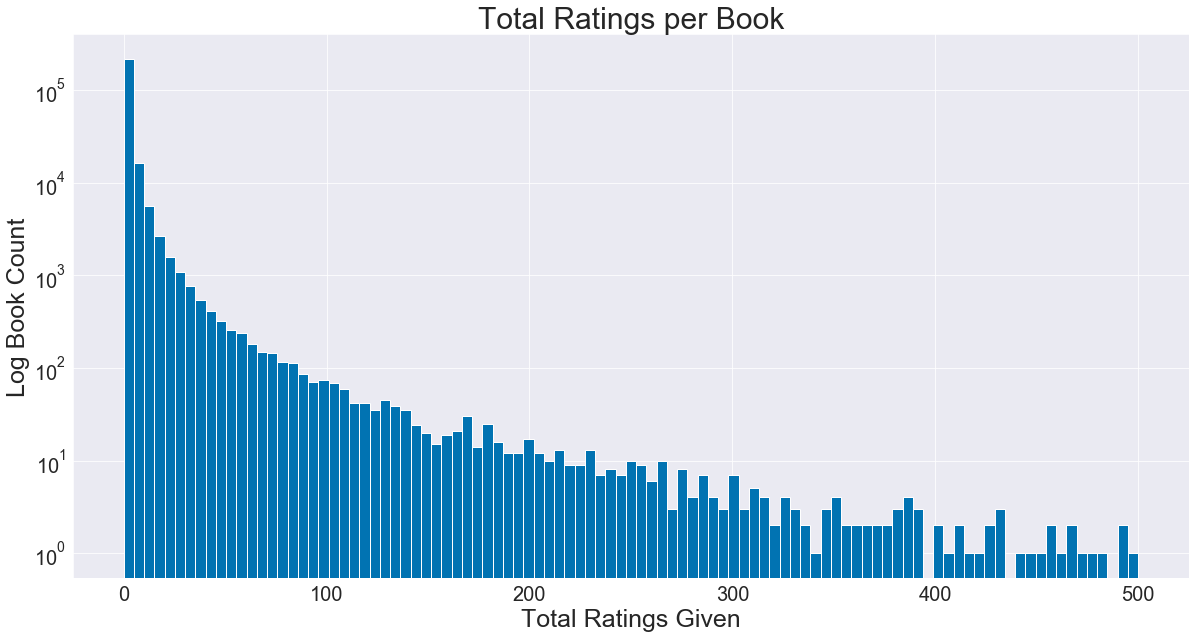

In [38]:
plt.figure(figsize=(20, 10))
plt.hist(x=ratings_and_books['isbn'].value_counts().values,
         bins=np.linspace(0,500,100))
plt.gca().set_yscale("log")
plt.title('Total Ratings per Book', fontsize=30)
plt.xlabel('Total Ratings Given', fontsize=25)
plt.ylabel('Log Book Count', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

## Explicit and Implicit Ratings

In [39]:
exp_ratings = ratings_and_books[ratings_and_books['book_rating'] != 0] 

In [40]:
exp_ratings[['book_rating']].describe().T

,count,mean,std,min,25%,50%,75%,max
book_rating,383852.0,7.62671,1.841331,1.0,7.0,8.0,9.0,10.0


In [41]:
imp_ratings = ratings_and_books[ratings_and_books['book_rating'] == 0]

In [42]:
print("Explicit:", exp_ratings.shape[0])
print("Implicit:", imp_ratings.shape[0])

Explicit: 383852
Implicit: 647323


In [43]:
exp_ratings.groupby(
    ['isbn', 'book_title'], as_index=False)[['book_rating']].count().rename(
    columns={'book_rating': 'explicit_count'})

,isbn,book_title,explicit_count
0,0000913154,The Way Things Work: An Illustrated Encycloped...,1
1,0001046438,Liar,3
2,000104687X,"T.S. Eliot Reading \The Wasteland\"" and Other ...",1
3,0001047213,The Fighting Man,1
4,000104799X,Monk's-hood,2
5,0001053736,Sir Gawain and the Green Knight,1
6,0001053744,Pearl and Sir Orfeo,1
7,0001055607,Cereus Blooms At Night,1
8,0001056107,Farmer Giles of Ham: And Other Stories,2
9,0001061127,CHESS FOR YOUNG BEGINNERS,1


In [44]:
imp_count = imp_ratings.groupby(
    ['isbn', 'book_title'], as_index=False)[['book_rating']].count().rename(
    columns={'book_rating': 'implicit_count'})

exp_count = exp_ratings.groupby(
    ['isbn', 'book_title'], as_index=False)[['book_rating']].count().rename(
    columns={'book_rating': 'explicit_count'})

In [45]:
ratings_count = imp_count.merge(exp_count.drop(columns='book_title'), 
                                how='outer', 
                                on='isbn').fillna(0).astype({'implicit_count': int, 'explicit_count': int})

In [46]:
ratings_count['total_count'] = ratings_count['implicit_count'] + ratings_count['explicit_count']

In [47]:
ratings_count.sort_values(by='total_count', ascending=False).head(10)

,isbn,book_title,implicit_count,explicit_count,total_count
153881,0971880107,Wild Animus,1921,581,2502
26543,0316666343,The Lovely Bones: A Novel,588,707,1295
52568,0385504209,The Da Vinci Code,399,488,887
22922,0312278586,The Nanny Diaries: A Novel,435,393,828
27313,0330332775,Bridget Jones's Diary,438,377,815
14922,0142001740,The Secret Life of Bees,368,406,774
4922,0060928336,Divine Secrets of the Ya-Ya Sisterhood: A Novel,417,323,740
22292,0312195516,The Red Tent (Bestselling Backlist),340,383,723
97681,0671027360,Angels &amp; Demons,360,310,670
15297,0151008116,Life of Pi,328,336,664


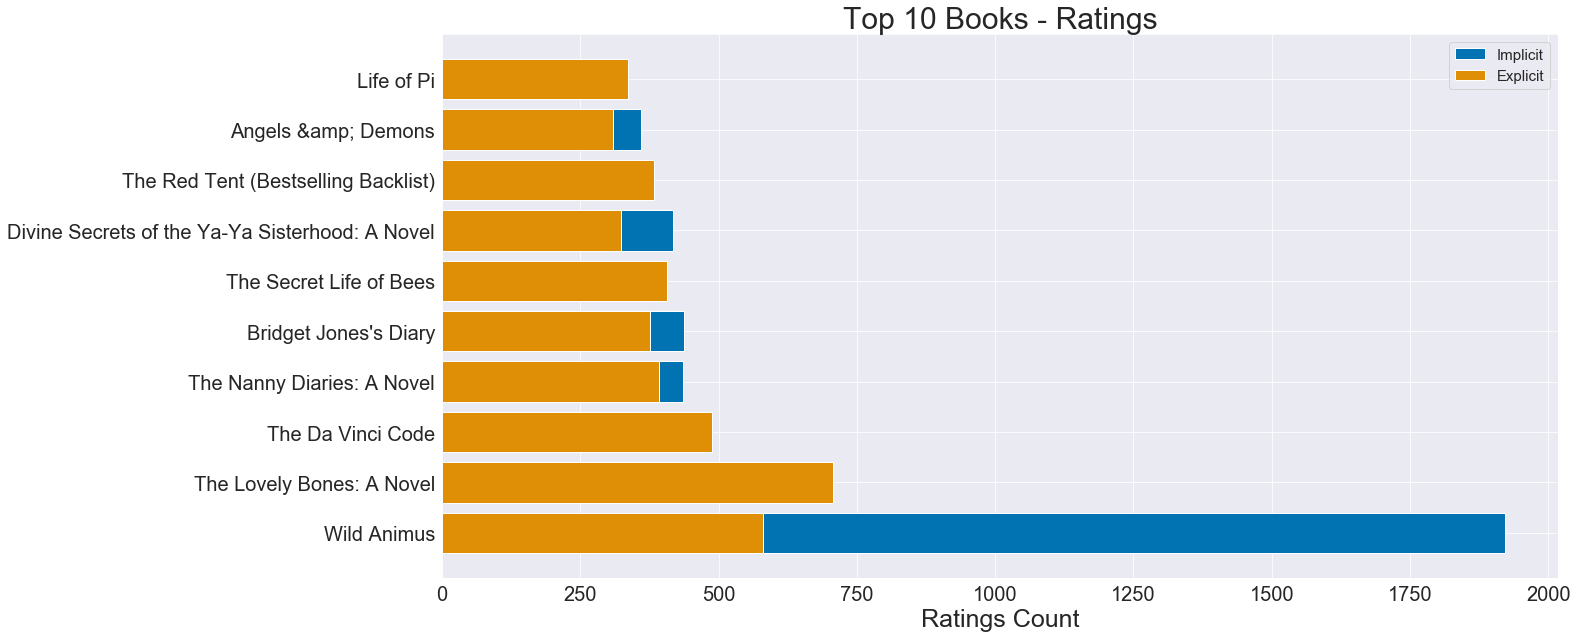

In [48]:
plt.figure(figsize=(20, 10))
plt.barh(y=ratings_count.sort_values(by='total_count', ascending=False)['book_title'].head(10),
         width=ratings_count.sort_values(by='total_count', ascending=False)['implicit_count'].head(10))
plt.barh(y=ratings_count.sort_values(by='total_count', ascending=False)['book_title'].head(10),
         width=ratings_count.sort_values(by='total_count', ascending=False)['explicit_count'].head(10))
plt.legend(['Implicit', 'Explicit'], fontsize=15)
plt.title('Top 10 Books - Ratings', fontsize=30)
plt.xlabel('Ratings Count', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

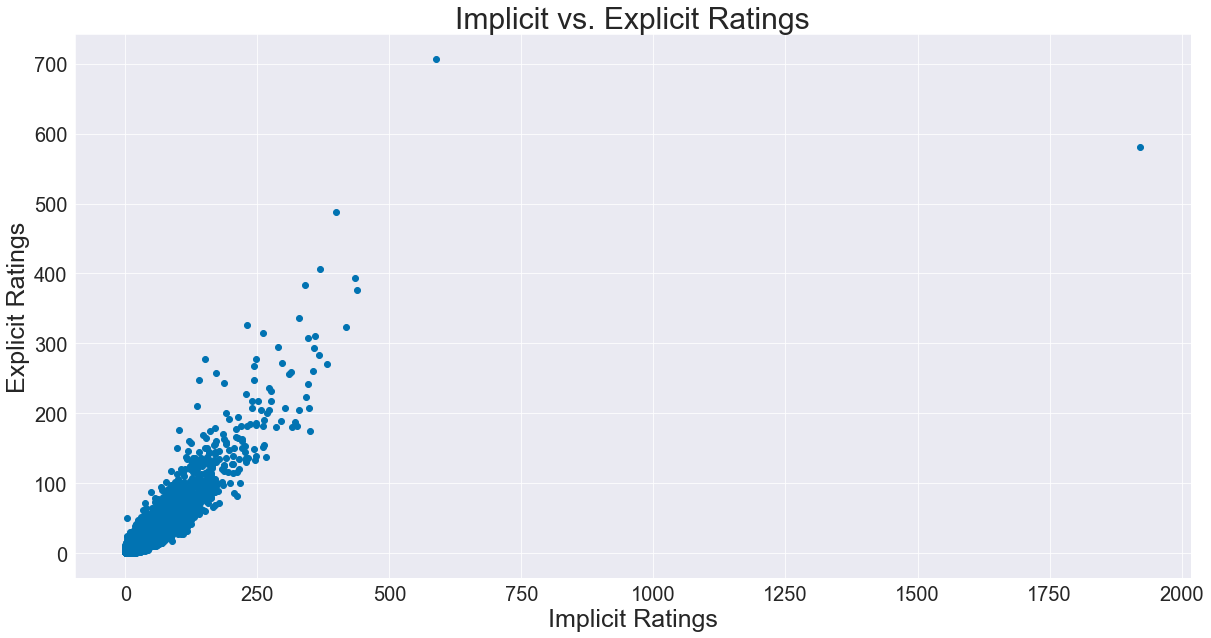

In [49]:
plt.figure(figsize=(20, 10))
plt.scatter(x=ratings_count['implicit_count'],
            y=ratings_count['explicit_count'])
plt.xlabel('Implicit Ratings', fontsize=25)
plt.ylabel('Explicit Ratings', fontsize=25)
plt.title('Implicit vs. Explicit Ratings', fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

## Explicit Ratings Threshold

In [50]:
isbn_greater_three = exp_ratings['isbn'].value_counts().index[exp_ratings['isbn'].value_counts().values > 3]

In [51]:
new_exp_ratings = exp_ratings[exp_ratings['isbn'].isin(isbn_greater_three)]

In [52]:
print('Users:  ', new_exp_ratings['user_id'].nunique())
print('Books:  ', new_exp_ratings['isbn'].nunique())
print('Ratings:', new_exp_ratings.shape[0])

Users:   51762
Books:   18263
Ratings: 224114


In [53]:
# new_exp_ratings.to_sql(name='exp_ratings',
#                        con=engine,
#                        index=False)

In [54]:
new_exp_ratings.to_csv('../data/explicit_ratings.csv')

In [61]:
new_exp_ratings.head()

,isbn,book_title,book_author,year_of_publication,publisher,user_id,book_rating
2,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,8,5
4,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,11676,8
6,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,67544,8
9,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,116866,9
10,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,123629,9


## Sparse DataFrame

In [55]:
# ratings_list = exp_ratings.to_dict('list')

# wide_ratings = {}
# for user, book, rating in zip(exp_ratings['user_id'], exp_ratings['isbn'], exp_ratings['book_rating']):
#     if wide_ratings.get(user):
#         wide_ratings[user][book] = rating
#     else:
#         wide_ratings[user] = {book: rating}

# sdf_ratings = pd.SparseDataFrame(wide_ratings)

# sdf_ratings.head()

# sdf_ratings_scaled = (sdf_ratings - np.nanmean(sdf_ratings, axis=0))/np.nanstd(sdf_ratings, axis=0) 